# 1. Data preparation

This is where every practical DreaMS project begins: converting your raw mass spectrometry data into a format that is efficient, and ready for machine learning.  
In this notebook, we also **clean the data, apply quality control filters, and keep only single positive-charge mass spectra**, since DreaMS is designed to work on those.


In [10]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd

# make PROJECT_ROOT available
sys.path.append(str(Path().resolve().parent))
from paths import PROJECT_ROOT

# DreaMS imports
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

from dreams.utils.data import MSData
from dreams.utils.dformats import DataFormatA
from dreams.utils.spectra import unpad_peak_list
from dreams.utils.io import append_to_stem

## 1.1 Loading and converting mass spectrometry data

In DreaMS, we use the `MSData` class to handle all spectral data. This object is your main interface for loading, exploring, filtering, and saving MS/MS spectra, and it works with the main mass spectrometry file formats: `.mzML` and `.mgf`.

### Why use MSData and HDF5?

- **Universal loader:** `MSData.load()` automatically detects your file type (`.mgf` or `.mzML`) and converts it into a single, easy-to-use object.
- **Automatic HDF5 conversion:** On the very first run, your data is converted to an HDF5 file, a binary format made for fast, large-scale access.
  - HDF5 makes it possible to access thousands of spectra rapidly
  - It uses much less disk space than text files
  - All metadata (precursor m/z, charge, SMILES, and more) is kept and easily accessible
- **Transparent caching:** Once converted, a `.hdf5` file will appear next to your original `.mgf` or `.mzML` file. All future loads will use this cached file, so you do not need to re-parse the text again.

For more details, see: [DreaMS documentation – Working with MS/MS data using HDF5](https://dreams-docs.readthedocs.io/en/latest/tutorials/msdata.html)

---

In [11]:
# If you want to use your own data, put the path to your file here.
# Be careful to use the full (absolute) path, or use PROJECT_ROOT as we do here.
spectra_path = PROJECT_ROOT / "data" / "Piper_sirius_all_annotated.mgf"
h5_path      = spectra_path.with_suffix('.hdf5')

In [12]:
if h5_path.exists():
    # If the HDF5 already exists, load it directly (this is fastest)
    msdata = MSData.from_hdf5(h5_path, in_mem=True)
else:
    # If not, convert from the original file and cache the result as HDF5
    msdata = MSData.load(
        spectra_path,
        in_mem=True,
        prec_mz_col="PRECURSOR_MZ"
    )

Loading dataset Piper_sirius_all_annotated into memory (6732 spectra)...


After running this code for the first time, check your `data/` folder:  
A new `.hdf5` file with the same name as your input file will be created.

From now on, all data processing will use this **HDF5 file** as the source, it is much faster, and you do not need to worry about re-parsing files.

> **Tip:**  
> If you ever change the original `.mgf` or `.mzML`, just delete the `.hdf5` file and rerun this cell to regenerate it.

### 1.2 Inspecting your data with the `MSData` object

### Check available columns and metadata

First, you can list all the columns (attributes) present in your dataset.  
These typically include the **precursor m/z**, **charge**, **file name**, and, if available, **SMILES**, **compound name**, and other metadata stored for each spectrum.

In [4]:

print("columns in MSData:", msdata.columns())

columns in MSData: ['COMPOUND_NAME', 'FEATURE_ID', 'FILE_NAME', 'FORMULA', 'INCHI', 'INCHIKEY', 'MS_LEVEL', 'NUM_PEAKS', 'RETENTION_TIME', 'SCANS', 'SPECTYPE', 'adduct', 'charge', 'precursor_mz', 'smiles', 'spectrum']


### Visualize a single spectrum and its metadata

You can quickly inspect the data and metadata for any individual spectrum by its index (here, we use the first spectrum at index 0):

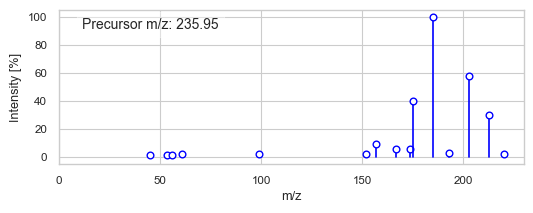

[10:52:36] SMILES Parse Error: syntax error while parsing: None
[10:52:36] SMILES Parse Error: Failed parsing SMILES 'None' for input: 'None'


None

{'COMPOUND_NAME': 'None',
 'FEATURE_ID': 1,
 'FILE_NAME': 'nan',
 'FORMULA': 'None',
 'INCHI': 'None',
 'INCHIKEY': 'None',
 'MS_LEVEL': 2,
 'NUM_PEAKS': 15,
 'RETENTION_TIME': 51.58,
 'SCANS': 1,
 'SPECTYPE': 'nan',
 'adduct': 'nan',
 'charge': '1+',
 'precursor_mz': 235.95224,
 'smiles': 'None'}

In [5]:
msdata.at(1)

Each spectrum in `MSData` not only contains the **peak list**, but also keeps track of its **source file**, the **scan number**, and all **annotation fields**.  
This is useful, later, you’ll always be able to trace any processed spectrum back to its origin.

### Accessing the peak lists as arrays

`MSData` stores all your spectra as a single large **3D array** for efficiency.  
When you run:

In [6]:
spectra = msdata.get_spectra()  # numpy ndarray, shape (N, 2, P)
print(spectra.shape)

(6732, 2, 128)


You’ll get:

- **N**: number of spectra (e.g., 6732)  
- **2**: two arrays per spectrum (`m/z` and intensity)  
- **P**: each spectrum is padded to the same length for compatibility with ML models

For example, `spectra[0][0]` gives you the **m/z values** for the first spectrum, and `spectra[0][1]` gives the **corresponding intensities**.

In [7]:
spectra[1][1]

array([  1.72 ,   1.682,   1.708,   1.853,   1.829,   1.901,   9.295,
         5.988,   5.721,  40.281, 100.   ,   2.458,  57.758,  29.867,
         2.113,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,
         0.   ,   0.

### Inspecting an individual spectrum (padded)

Let’s look at the raw, padded values for the first spectrum:

In [8]:
np.set_printoptions(precision=4, suppress=True)
print(spectra[1])

[[ 44.9044  53.3828  55.9312  61.1137  98.8067 151.7258 156.9462 166.9305
  173.5269 174.9568 184.9411 192.9681 202.9518 212.9362 219.9713   0.
    0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.       0.
    0.       0.       0.       0.       0.       0.       0.       0.
    0.       0. 

You’ll see that some values at the end are zeros, these are just padding, so all spectra are the same size.

> **Note:**  
> These zeros will not influence DreaMS, they are ignored.

### Remove padding to get the real peaks

To work with just the real (non-zero) peaks, use the `unpad_peak_list` function:

In [9]:
s0 = unpad_peak_list(spectra[1])
print(s0)  # shape (n_peaks, 2)

[[ 44.9044  53.3828  55.9312  61.1137  98.8067 151.7258 156.9462 166.9305
  173.5269 174.9568 184.9411 192.9681 202.9518 212.9362 219.9713]
 [  1.72     1.682    1.708    1.853    1.829    1.901    9.295    5.988
    5.721   40.281  100.       2.458   57.758   29.867    2.113 ]]


### Accessing specific metadata values

The `MSData` object makes it easy to pull out metadata for all or just some spectra.  
For example, you can quickly check the **charge state** of each spectrum.

In [9]:
msdata.get_values('charge') 


['1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',
 '1+',

This gives you a list of charge states for every spectrum in your dataset.

**Get the value for a specific spectrum**

If you want just the charge of the first spectrum:

In [10]:
msdata.get_values('charge', [0])  

['1+']



You can also fetch, for example, the charge states for spectra 0 through 3:

In [11]:
msdata.get_values('charge', [0, 1, 2, 3])  

['1+', '1+', '1+', '1+']


## 1.3 Filtering to single-charge positive-ion spectra only

DreaMS is designed specifically for spectra acquired in **single positive ionization mode (1+)**.  
While your data may also include **doubly-charged (2+)** or even higher, for this workflow we will keep only the **singly-charged spectra**.

In [9]:
# Get all charges (as strings, e.g. ['1+', '2+', '1+', '0'])
raw_charges = msdata.get_values("charge")

# Convert to integer charges: strip any '+' or '−', then convert to int
charges = np.array([int(''.join(ch.strip().rstrip('+-−'))) for ch in raw_charges])

# Keep only spectra with charge == 1
single_pos_idx = np.where(charges == 1)[0]
print(f"keeping {len(single_pos_idx)} / {len(charges)} spectra with charge == 1")

keeping 6720 / 6732 spectra with charge == 1


Depending on your data, the charge notation (`1+`, `2+`, etc.) might differ.  
**Always double-check** how charge is stored in your dataset and adjust your filter if needed.

Now, create a new `MSData` object with only the **singly-charged positive-ion spectra**, and save it as a new **HDF5 file**:

In [10]:
hq_h5 = PROJECT_ROOT / "data" / "Piper_sirius_all_annotated_pos.hdf5"
msdata_pos = msdata.form_subset(single_pos_idx, out_pth=hq_h5)

This subset is what you will use for the next steps in **data cleaning** and **preparation**.

## 1.4 Quality control: keeping only high-quality spectra


Before using our mass spectra for machine learning, we need to make sure they meet basic quality criteria.  
Low-quality or incomplete spectra can negatively affect both training and downstream analysis.

The DreaMS framework provides **quality control (QC)** checks for each spectrum.  
Only spectra that pass all QC metrics will be kept for further analysis.

---

### Preparing spectra for QC

To perform quality control, we need to extract:

- The spectra (as an array of `m/z` and intensity pairs, one for each spectrum)
- The precursor `m/z` values (one per spectrum)

The code below does this.  
Don’t worry about array shapes, DreaMS framework handles the formatting for you.

In [12]:
spectra = msdata_pos.get_spectra()    # shape: (M, 2, P), padded
prec_mzs = msdata_pos.get_prec_mzs()  # shape: (M,)

# Unpad each spectrum to remove zeros before checking intensity-based QC
spectra = [unpad_peak_list(s) for s in spectra]

### Running the quality control check

We use the `DataFormatA` class and its `val_spec` function to check each spectrum and its precursor `m/z`.  
QC checks include **minimum peak count**, **precursor m/z plausibility**, **intensity patterns**, and more.

In [13]:
from dreams.utils.dformats import DataFormatA

dformat = DataFormatA()
quality_lvls = [
    dformat.val_spec(spec, prec, return_problems=True)
    for spec, prec in zip(spectra, prec_mzs)
]

You can check the results and see how many spectra passed all checks:

In [14]:
pd.Series(quality_lvls).value_counts()

All checks passed                      4758
Number of high intensity peaks >= 3     954
Intensity amplitude >= 20.0             942
Number of peaks between 3 and 128        61
m/z range <= 1000.0                       5
Name: count, dtype: int64

### Filtering to high-quality spectra

Now, keep only the spectra that passed all metrics:

In [29]:
pass_idx = np.where(np.array(quality_lvls) == "All checks passed")[0]
print(f"{len(pass_idx)} spectra passed all QC out of {len(quality_lvls)}")

from dreams.utils.io import append_to_stem
clean_h5 = append_to_stem(h5_path, "high_quality")
msdata_hq = msdata_pos.form_subset(pass_idx, out_pth=clean_h5)
print(msdata_hq)

4758 spectra passed all QC out of 6720
MSData(pth=/Users/macbook/CODE/DreaMS_MIMB/data/Piper_sirius_all_annotated_high_quality.hdf5, in_mem=False) with 4,758 spectra.


The new file (ending with `_high_quality.hdf5`) contains only the spectra that are **positive-ion**, **singly charged**, and **high quality**.

---

## 1.5 next steps

You now have a clean, positive-ion, high-quality HDF5 file ready for **downstream embedding and clustering**.  
Proceed to `2_deduplication.ipynb` for **LSH deduplication** and **DreaMS encoding**.

### 1.6 Work with large dataset

The **MSData** class enables working with **huge files** without loading all their content into memory.  

Let’s look at an example using the **large-scale GeMS-A10 dataset** introduced in the [DreaMS paper](https://www.nature.com/articles/s41587-025-02663-3).  

But first, we need to **download it**, since the **base setup** does not include the GeMS dataset:

In [17]:
!python ../scripts/download_gems.py 

[INFO] Downloading roman-bushuiev/MassSpecGym/data/spectra/GeMS_A10.hdf5
[INFO] Destination: /Users/macbook/CODE/DreaMS_MIMB/data/spectra/GeMS_A10.hdf5
/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
[OK] Download complete (via huggingface_hub).


In [21]:
path_gems = PROJECT_ROOT /"data" / "spectra" / "GeMS_A10.hdf5"
!ls -lhtr ../data/spectra/GeMS_A10.hdf5

-rw-r--r--@ 3 macbook  staff    14G Aug 10 14:15 ../data/spectra/GeMS_A10.hdf5


The **GeMS-A10** dataset takes **14 GB** on disk (the uncompressed HDF5 version would take **47 GB**), which is too large to fit into the RAM of an average laptop.  

Nevertheless, `MSData` allows for **efficient handling** of the file by loading only the **necessary chunks of data** at a time.

In [22]:
msdata_gems = MSData.from_hdf5(path_gems, in_mem=False)
print(f'{path_gems} contains {len(msdata_gems)} spectra.')

/Users/macbook/CODE/DreaMS_MIMB/data/spectra/GeMS_A10.hdf5 contains 23517534 spectra.


When setting `in_mem=False` in the `MSData` constructor, none of the spectra or their metadata are loaded into memory initially.  
The data is loaded **only when it is accessed**.

For example, let’s retrieve the **first 50 spectra**:

In [23]:
msdata_gems.get_spectra(range(50)).shape

(50, 2, 128)

Or retrieve the **first 50 precursor m/z values**.


In [24]:
msdata_gems.get_prec_mzs(range(50)).shape

(50,)

To get **all precursor m/z values** (and load them into memory),  
you can use either of the two equivalent options:

In [25]:
msdata_gems.get_prec_mzs().shape, msdata_gems['precursor_mz'].shape

((23517534,), (23517534,))

However, note that using `msdata['precursor_mz'][:50]` is **deprecated** for large datasets, because `msdata['precursor_mz']` first loads **all** the values into memory, and only then `[:50]` retrieves a chunk.